In [1]:
%pip uninstall numpy tensorflow opencv-python -y
%pip install numpy==1.26.4 tensorflow==2.16.2 Pillow scikit-learn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached tensorflow-2.16.2-cp312-cp312-macosx_10_15_x86_64.whl.metadata (4.1 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
Using cached tensorflow-2.16.2-cp312-cp312-macosx_10_15_x86_64.whl (259.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorflow] 1/2 [tensorflow]
Note: you may need to restart the kernel to use updated packages.


## 1. Imports

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ All imports successful!")

2025-10-27 14:01:41.090553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ TensorFlow version: 2.16.2
✓ NumPy version: 1.26.4
✓ All imports successful!


## 2. Configuration

In [3]:
# EDIT THIS: Path to your Pokemon Images folder
DATA_DIR = 'images'

# Training configuration
IMG_SIZE = (64, 64)  # Start small for speed
NUM_CLIENTS = 3
NUM_ROUNDS = 5
DIRICHLET_ALPHA = 0.5  # Lower = more non-IID (0.1 to 5.0)
BATCH_SIZE = 32
EPOCHS_PER_ROUND = 1

# DLG Attack configuration
ATTACK_ITERATIONS = 300
ATTACK_LR = 0.1
ATTACK_REG = 0.001

print("Configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Image size: {IMG_SIZE}")
print(f"  Clients: {NUM_CLIENTS}, Rounds: {NUM_ROUNDS}")
print(f"  Dirichlet alpha: {DIRICHLET_ALPHA}")

Configuration:
  Data directory: images
  Image size: (64, 64)
  Clients: 3, Rounds: 5
  Dirichlet alpha: 0.5


## 3. Pokemon Data Loader

In [4]:
class PokemonDataLoader:
    """Load and partition Pokemon dataset"""
    
    def __init__(self, data_dir, img_size):
        self.data_dir = data_dir
        self.img_size = img_size
        self.label_to_idx = {}
        self.idx_to_label = {}
    
    def load_dataset(self):
        """Load all Pokemon images"""
        images = []
        labels = []
        
        # Get Pokemon folders
        pokemon_folders = sorted([f for f in os.listdir(self.data_dir) 
                                 if os.path.isdir(os.path.join(self.data_dir, f))])
        
        # Create label mappings
        self.label_to_idx = {name: idx for idx, name in enumerate(pokemon_folders)}
        self.idx_to_label = {idx: name for name, idx in self.label_to_idx.items()}
        
        print(f"Found {len(pokemon_folders)} Pokemon classes")
        
        # Load images
        loaded_count = 0
        for pokemon_name in pokemon_folders:
            pokemon_path = os.path.join(self.data_dir, pokemon_name)
            label_idx = self.label_to_idx[pokemon_name]
            
            image_files = [f for f in os.listdir(pokemon_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in image_files:
                img_path = os.path.join(pokemon_path, img_file)
                try:
                    # Load with PIL and convert to numpy
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(self.img_size)
                    img = np.array(img, dtype=np.float32) / 255.0
                    
                    images.append(img)
                    labels.append(label_idx)
                    loaded_count += 1
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {loaded_count} images successfully")
        return np.array(images), np.array(labels)
    
    def partition_non_iid_dirichlet(self, images, labels, num_clients, alpha=0.5):
        """Partition data using Dirichlet distribution (non-IID)"""
        client_data = {i: {'images': [], 'labels': []} for i in range(num_clients)}
        
        # Group by class
        class_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            class_indices[label].append(idx)
        
        # Shuffle within each class
        for label in class_indices:
            np.random.shuffle(class_indices[label])
        
        # Distribute using Dirichlet
        for label, indices in class_indices.items():
            proportions = np.random.dirichlet(alpha * np.ones(num_clients))
            proportions = (proportions * len(indices)).astype(int)
            proportions[0] += len(indices) - proportions.sum()  # Adjust for rounding
            
            start_idx = 0
            for client_id in range(num_clients):
                end_idx = start_idx + proportions[client_id]
                client_indices = indices[start_idx:end_idx]
                
                client_data[client_id]['images'].extend(images[client_indices])
                client_data[client_id]['labels'].extend(labels[client_indices])
                
                start_idx = end_idx
        
        # Convert to arrays
        for client_id in range(num_clients):
            client_data[client_id]['images'] = np.array(client_data[client_id]['images'])
            client_data[client_id]['labels'] = np.array(client_data[client_id]['labels'])
        
        return client_data
    
    def train_test_split_client(self, images, labels, test_size=0.2):
        """Split client data into train/test"""
        if len(images) == 1:
            return images, labels, images, labels
        
        x_train, x_test, y_train, y_test = train_test_split(
            images, labels, test_size=test_size, random_state=42
        )
        return x_train, y_train, x_test, y_test

print("✓ PokemonDataLoader class defined")

✓ PokemonDataLoader class defined


## 4. Model Creation

In [5]:
def create_pokemon_model(input_shape, num_classes):
    """Create CNN for Pokemon classification"""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Dense
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ Model creation function defined")

✓ Model creation function defined


## 5. DLG Attack Implementation

In [6]:
class DLGAttacker:
    """Deep Leakage from Gradients Attack"""
    
    def __init__(self, model):
        self.model = model
    
    def compute_gradients(self, x_batch, y_batch):
        """Compute gradients for a batch"""
        with tf.GradientTape() as tape:
            predictions = self.model(x_batch, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, predictions)
            loss = tf.reduce_mean(loss)
        return tape.gradient(loss, self.model.trainable_variables)
    
    def gradient_matching_loss(self, dummy_grads, target_grads):
        """Compute loss between dummy and target gradients"""
        total_loss = 0.0
        for dg, tg in zip(dummy_grads, target_grads):
            if dg is not None and tg is not None:
                total_loss += tf.reduce_sum((dg - tg) ** 2)
        return total_loss
    
    def attack(self, target_gradients, target_label, num_classes, img_shape,
               num_iterations=300, learning_rate=0.1, regularization=0.001):
        """Perform DLG attack"""
        # Initialize dummy data
        dummy_data = tf.Variable(tf.random.normal(shape=(1,) + img_shape), trainable=True)
        dummy_label = tf.Variable(tf.constant([target_label], dtype=tf.int32), trainable=False)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss_history = []
        
        print("Starting DLG attack...")
        for iteration in range(num_iterations):
            with tf.GradientTape() as tape:
                # Compute gradients with dummy data
                dummy_grads = self.compute_gradients(dummy_data, dummy_label)
                
                # Gradient matching loss
                grad_loss = self.gradient_matching_loss(dummy_grads, target_gradients)
                
                # Total variation regularization
                tv_loss = (
                    tf.reduce_sum(tf.abs(dummy_data[:, :, :-1, :] - dummy_data[:, :, 1:, :])) +
                    tf.reduce_sum(tf.abs(dummy_data[:, :-1, :, :] - dummy_data[:, 1:, :, :]))
                )
                
                # L2 regularization
                l2_loss = tf.reduce_sum(dummy_data ** 2)
                
                total_loss = grad_loss + regularization * (tv_loss + l2_loss)
            
            # Update dummy data
            grads = tape.gradient(total_loss, [dummy_data])
            optimizer.apply_gradients(zip(grads, [dummy_data]))
            
            # Clamp to [0, 1]
            dummy_data.assign(tf.clip_by_value(dummy_data, 0.0, 1.0))
            
            loss_history.append(float(total_loss))
            
            if iteration % 50 == 0:
                print(f"  Iteration {iteration}/{num_iterations}, Loss: {total_loss:.4f}")
        
        print("DLG attack completed!")
        return dummy_data.numpy()[0], dummy_label.numpy()[0], loss_history

print("✓ DLGAttacker class defined")

✓ DLGAttacker class defined


## 6. Load Dataset

In [7]:
# Initialize loader
loader = PokemonDataLoader(data_dir=DATA_DIR, img_size=IMG_SIZE)

# Load dataset
print("Loading Pokemon dataset...")
images, labels = loader.load_dataset()

print(f"\nDataset loaded:")
print(f"  Total images: {len(images)}")
print(f"  Image shape: {images[0].shape}")
print(f"  Number of Pokemon: {len(loader.label_to_idx)}")
print(f"  Label range: {labels.min()} to {labels.max()}")

Loading Pokemon dataset...
Found 898 Pokemon classes
Loaded 2503 images successfully

Dataset loaded:
  Total images: 2503
  Image shape: (64, 64, 3)
  Number of Pokemon: 898
  Label range: 0 to 897


## 7. Visualize Sample Pokemon

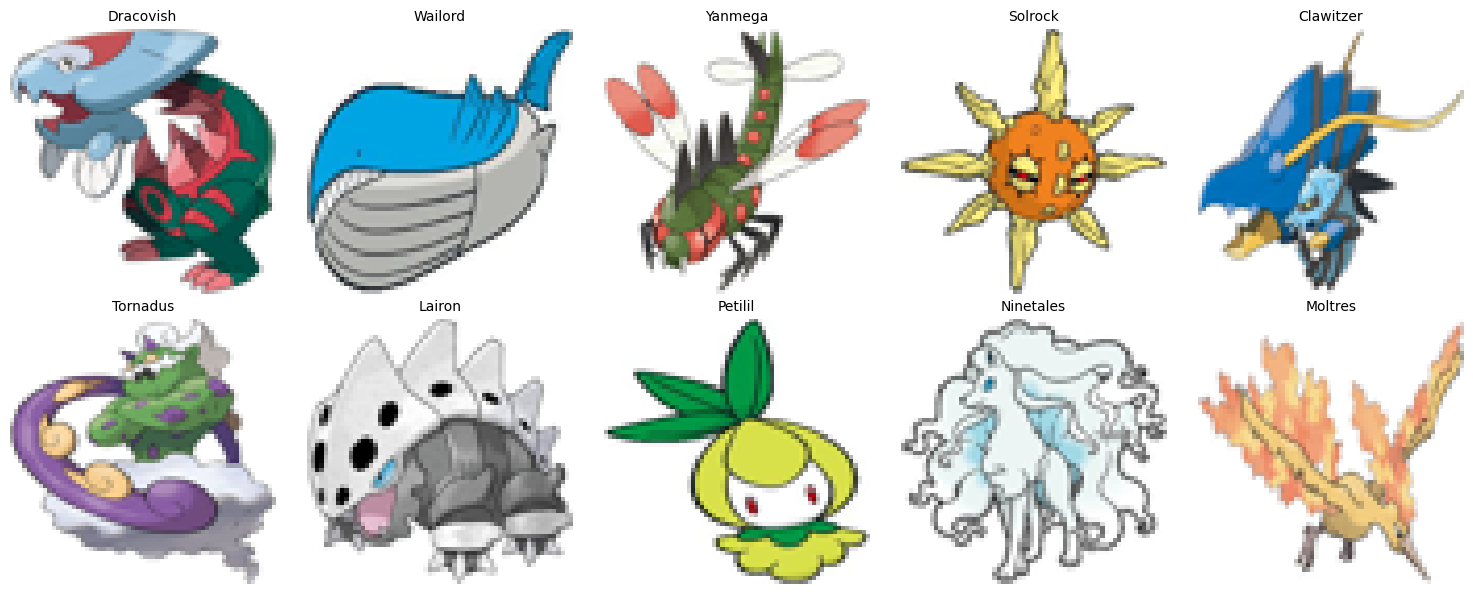

In [8]:
# Display random Pokemon
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

random_indices = np.random.choice(len(images), 10, replace=False)

for i, idx in enumerate(random_indices):
    axes[i].imshow(images[idx])
    pokemon_name = loader.idx_to_label[labels[idx]]
    axes[i].set_title(pokemon_name, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 8. Partition Data Across Clients

In [9]:
# Partition data
print(f"Partitioning data across {NUM_CLIENTS} clients (alpha={DIRICHLET_ALPHA})...")
client_data_dict = loader.partition_non_iid_dirichlet(
    images, labels, NUM_CLIENTS, alpha=DIRICHLET_ALPHA
)

# Analyze distribution
print(f"\nClient data distribution:")
for cid in range(NUM_CLIENTS):
    client_images = client_data_dict[cid]['images']
    client_labels = client_data_dict[cid]['labels']
    unique_classes = len(np.unique(client_labels))
    
    print(f"  Client {cid}: {len(client_labels)} samples, {unique_classes} unique Pokemon")
    
    # Show top 3 Pokemon
    unique, counts = np.unique(client_labels, return_counts=True)
    top_indices = np.argsort(counts)[-3:][::-1]
    print(f"    Top Pokemon: ", end="")
    for idx in top_indices:
        pokemon_name = loader.idx_to_label[unique[idx]]
        print(f"{pokemon_name}({counts[idx]})", end=" ")
    print()

Partitioning data across 3 clients (alpha=0.5)...

Client data distribution:
  Client 0: 1529 samples, 898 unique Pokemon
    Top Pokemon: Venusaur(7) Vivillon(6) Grimer(6) 
  Client 1: 495 samples, 318 unique Pokemon
    Top Pokemon: Meowth(5) Necrozma(5) Ponyta(5) 
  Client 2: 479 samples, 323 unique Pokemon
    Top Pokemon: Muk(5) Metagross(5) Gourgeist(4) 


## 9. Simple Training (One Client, No Federation)

In [10]:
# Use client 0's data for simple training
client_0_images = client_data_dict[0]['images']
client_0_labels = client_data_dict[0]['labels']

# Split into train/test
x_train, y_train, x_test, y_test = loader.train_test_split_client(
    client_0_images, client_0_labels
)

print(f"Client 0 data:")
print(f"  Training: {len(x_train)} samples")
print(f"  Testing: {len(x_test)} samples")

# Create model
num_classes = len(loader.label_to_idx)
model = create_pokemon_model(
    input_shape=IMG_SIZE + (3,),
    num_classes=num_classes
)

print(f"\nModel created with {num_classes} output classes")
print("\nTraining for a few epochs...")

# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=3,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("\n✓ Training completed!")

Client 0 data:
  Training: 1223 samples
  Testing: 306 samples

Model created with 898 output classes

Training for a few epochs...
Epoch 1/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.0041 - loss: 6.9774 - val_accuracy: 0.0000e+00 - val_loss: 7.8345
Epoch 2/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.0327 - loss: 6.4459 - val_accuracy: 0.0000e+00 - val_loss: 8.9143
Epoch 3/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step - accuracy: 0.0932 - loss: 5.8854 - val_accuracy: 0.0000e+00 - val_loss: 10.3551

✓ Training completed!


## 10. Perform DLG Attack

Target Pokemon: Swirlix
Target label: 766


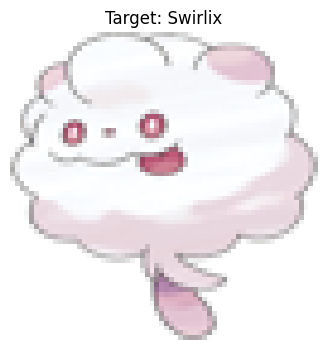

In [11]:
# Select a random training sample as target
target_idx = np.random.randint(0, len(x_train))
target_image = x_train[target_idx:target_idx+1]
target_label = y_train[target_idx:target_idx+1]

pokemon_name = loader.idx_to_label[int(target_label[0])]
print(f"Target Pokemon: {pokemon_name}")
print(f"Target label: {target_label[0]}")

# Display target
plt.figure(figsize=(4, 4))
plt.imshow(target_image[0])
plt.title(f"Target: {pokemon_name}")
plt.axis('off')
plt.show()

In [12]:
# Initialize attacker
attacker = DLGAttacker(model)

# Compute target gradients (this is what the attacker "steals")
print("Computing target gradients...")
target_gradients = attacker.compute_gradients(target_image, target_label)

print(f"✓ Captured {len(target_gradients)} gradient tensors")
total_params = sum(np.prod(g.shape) for g in target_gradients if g is not None)
print(f"✓ Total gradient parameters: {total_params:,}")

Computing target gradients...
✓ Captured 26 gradient tensors
✓ Total gradient parameters: 2,468,770


In [13]:
# Perform DLG attack
print("\nPerforming DLG attack...")
print("This will take a few minutes...\n")

reconstructed_image, reconstructed_label, loss_history = attacker.attack(
    target_gradients=target_gradients,
    target_label=int(target_label[0]),
    num_classes=num_classes,
    img_shape=IMG_SIZE + (3,),
    num_iterations=ATTACK_ITERATIONS,
    learning_rate=ATTACK_LR,
    regularization=ATTACK_REG
)

print("\n✓ Attack completed!")


Performing DLG attack...
This will take a few minutes...

Starting DLG attack...
  Iteration 0/300, Loss: 40.5677
  Iteration 50/300, Loss: 0.8644
  Iteration 100/300, Loss: 1.0622
  Iteration 150/300, Loss: 0.9870
  Iteration 200/300, Loss: 0.7846
  Iteration 250/300, Loss: 0.9574
DLG attack completed!

✓ Attack completed!


## 11. Visualize Attack Results

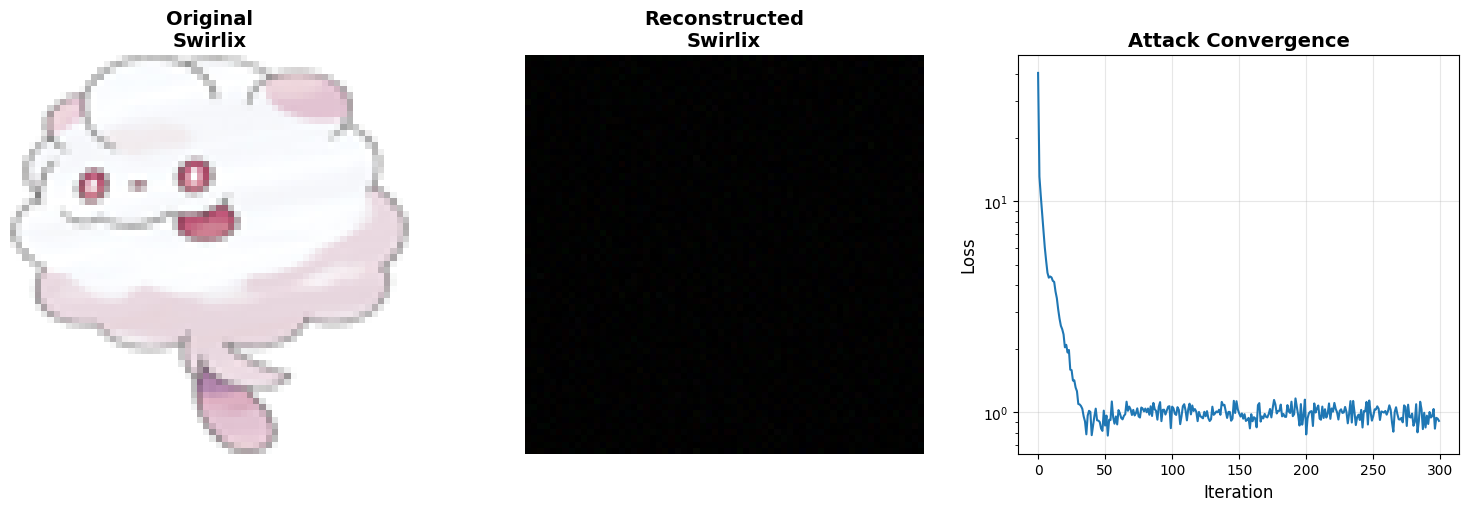

✓ Visualization saved as 'dlg_attack_result.png'


In [14]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(target_image[0])
axes[0].set_title(f'Original\n{pokemon_name}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Reconstructed image
axes[1].imshow(reconstructed_image)
axes[1].set_title(f'Reconstructed\n{loader.idx_to_label[reconstructed_label]}', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Loss curve
axes[2].plot(loss_history)
axes[2].set_xlabel('Iteration', fontsize=12)
axes[2].set_ylabel('Loss', fontsize=12)
axes[2].set_title('Attack Convergence', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dlg_attack_result.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'dlg_attack_result.png'")

## 12. Analysis & Metrics

In [15]:
# Compute reconstruction quality metrics
mse = np.mean((target_image[0] - reconstructed_image) ** 2)
psnr = 10 * np.log10(1.0 / mse)

print("Attack Quality Metrics:")
print(f"  Mean Squared Error: {mse:.6f}")
print(f"  Peak Signal-to-Noise Ratio: {psnr:.2f} dB")
print(f"  Final Loss: {loss_history[-1]:.2e}")
print(f"  Label Match: {'✓ Yes' if reconstructed_label == target_label[0] else '✗ No'}")

# Pixel-wise difference
diff = np.abs(target_image[0] - reconstructed_image)
print(f"  Mean Pixel Difference: {np.mean(diff):.4f}")
print(f"  Max Pixel Difference: {np.max(diff):.4f}")

Attack Quality Metrics:
  Mean Squared Error: 0.872776
  Peak Signal-to-Noise Ratio: 0.59 dB
  Final Loss: 9.09e-01
  Label Match: ✓ Yes
  Mean Pixel Difference: 0.9283
  Max Pixel Difference: 1.0000


## 13. Experiment: Try Different Attack Parameters


Testing: Fast (200 iters)
Starting DLG attack...
  Iteration 0/200, Loss: 40.6161
  Iteration 50/200, Loss: 1.0369
  Iteration 100/200, Loss: 0.9450
  Iteration 150/200, Loss: 1.1114
DLG attack completed!

Testing: Slow (500 iters)
Starting DLG attack...
  Iteration 0/500, Loss: 40.2329
  Iteration 50/500, Loss: 0.9940
  Iteration 100/500, Loss: 0.8860
  Iteration 150/500, Loss: 1.0529
  Iteration 200/500, Loss: 0.9897
  Iteration 250/500, Loss: 1.0069
  Iteration 300/500, Loss: 0.9345
  Iteration 350/500, Loss: 0.9698
  Iteration 400/500, Loss: 0.9352
  Iteration 450/500, Loss: 0.8544
DLG attack completed!

Testing: Lower LR
Starting DLG attack...
  Iteration 0/300, Loss: 39.9254
  Iteration 50/300, Loss: 1.0369
  Iteration 100/300, Loss: 0.9663
  Iteration 150/300, Loss: 0.9731
  Iteration 200/300, Loss: 0.8582
  Iteration 250/300, Loss: 0.7834
DLG attack completed!


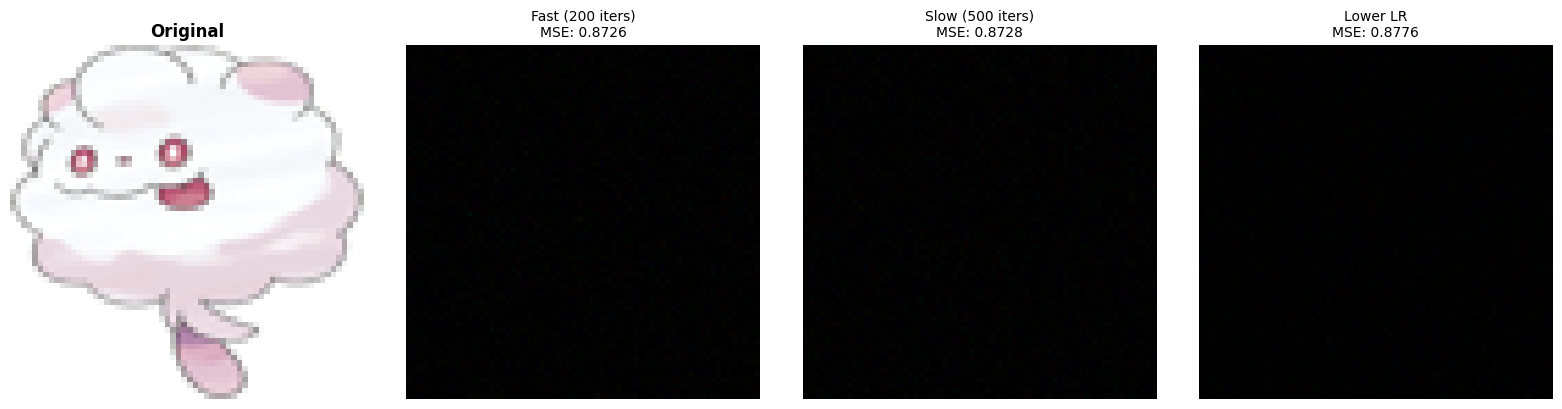


✓ Parameter comparison complete!


In [16]:
# Test different configurations
configs = [
    {'iters': 200, 'lr': 0.1, 'reg': 0.001, 'name': 'Fast (200 iters)'},
    {'iters': 500, 'lr': 0.1, 'reg': 0.001, 'name': 'Slow (500 iters)'},
    {'iters': 300, 'lr': 0.05, 'reg': 0.001, 'name': 'Lower LR'},
]

results = []

for config in configs:
    print(f"\nTesting: {config['name']}")
    
    recon_img, recon_label, loss_hist = attacker.attack(
        target_gradients=target_gradients,
        target_label=int(target_label[0]),
        num_classes=num_classes,
        img_shape=IMG_SIZE + (3,),
        num_iterations=config['iters'],
        learning_rate=config['lr'],
        regularization=config['reg']
    )
    
    mse = np.mean((target_image[0] - recon_img) ** 2)
    results.append({
        'config': config,
        'image': recon_img,
        'mse': mse,
        'final_loss': loss_hist[-1]
    })

# Compare results
fig, axes = plt.subplots(1, len(configs) + 1, figsize=(4 * (len(configs) + 1), 4))

axes[0].imshow(target_image[0])
axes[0].set_title('Original', fontweight='bold')
axes[0].axis('off')

for i, result in enumerate(results):
    axes[i+1].imshow(result['image'])
    axes[i+1].set_title(f"{result['config']['name']}\nMSE: {result['mse']:.4f}", fontsize=10)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Parameter comparison complete!")

## Summary

### What We Accomplished:

1. **✓ Loaded Pokemon dataset** with folder-based labels
2. **✓ Partitioned data** across N clients using Dirichlet distribution
3. **✓ Trained a CNN model** on Pokemon classification
4. **✓ Performed DLG attack** to reconstruct training images from gradients
5. **✓ Analyzed attack quality** with multiple metrics

### Key Observations:

- **Data Distribution**: Dirichlet alpha controls how non-IID the data is
- **Attack Quality**: Depends on model training, iterations, and hyperparameters
- **Privacy Risk**: Gradients can leak training data information

### Next Steps:

1. Implement full federated learning with Flower
2. Test defense mechanisms (gradient clipping, differential privacy)
3. Experiment with different model architectures
4. Try attacks at different training stages